### Install Dependencies
Install the AutoRA core package and the optional theorist/experimentalist extras via `pip`. The `%%capture` magic hides the verbose installation logs to keep the notebook tidy.

In [56]:
%%capture
!pip install autora
!pip install autora[all-theorists]
!pip install autora[all-experimentalists]

# ADD YOUR GITHUB REPO LINK HERE
#!pip install git+https://github.com/acesmeci/autora-experimentalist-MAFT

### Import Required Libraries
Load the AutoRA state helpers, synthetic experiment runner, experimentalist utilities, theorists, and supporting scikit-learn / plotting libraries that we use throughout the walkthrough.

In [57]:
# autora state
from autora.state import State, StandardState, on_state, estimator_on_state, Delta, VariableCollection

# experiment_runner
from autora.experiment_runner.synthetic.neuroscience.task_switching import task_switching

# experimentalist
from autora.experimentalist.grid import grid_pool
from autora.experimentalist.random import random_pool, random_sample
from autora.experimentalist.falsification import falsification_sample
from autora.experimentalist.model_disagreement import model_disagreement_sample
from autora.experimentalist.uncertainty import uncertainty_sample

# theorist
from autora.theorist.bms import BMSRegressor

# sklearn
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn import linear_model

# general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import Optional, List


### Implement the Polynomial Theorist
Define `PolynomialRegressor`, a lightweight theorist that expands polynomial features and fits a linear regression model. A helper method prints the learned equation so we can inspect the model.

In [58]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

class PolynomialRegressor:
    """
    This theorist fits a polynomial function to the data.
    """

    def __init__(self, degree: int = 3):
      self.poly = PolynomialFeatures(degree=degree, include_bias=False)
      self.model = LinearRegression()

    def fit(self, x, y):
      features = self.poly.fit_transform(x, y)
      self.model.fit(features, y)
      return self

    def predict(self, x):
      features = self.poly.fit_transform(x)
      return self.model.predict(features)

    def print_eqn(self):
        # Extract the coefficients and intercept
        coeffs = self.model.coef_
        intercept = self.model.intercept_

        # Handle multi-output case by iterating over each output's coefficients and intercept
        if coeffs.ndim > 1:
            for idx in range(coeffs.shape[0]):
                equation = f"y{idx+1} = {intercept[idx]:.3f}"
                feature_names = self.poly.get_feature_names_out()
                for coef, feature in zip(coeffs[idx], feature_names):
                    equation += f" + ({coef:.3f}) * {feature}"
                print(equation)
        else:
            equation = f"y = {intercept:.3f}"
            feature_names = self.poly.get_feature_names_out()
            for coef, feature in zip(coeffs, feature_names):
                equation += f" + ({coef:.3f}) * {feature}"
            print(equation)



### Define the Custom State
Extend AutoRA's `State` into `CustomState`, enabling us to persist experimental conditions, observations, reference grids, and multiple fitted models (BMS, linear, polynomial) across discovery cycles.

In [59]:
# SET UP STATE
# Here, we use a non-standard State to be able to use a multiple models
@dataclass(frozen=True)
class CustomState(State):
    variables: Optional[VariableCollection] = field(
        default=None, metadata={"delta": "replace"}
    )
    conditions: Optional[pd.DataFrame] = field(
        default=None, metadata={"delta": "replace", "converter": pd.DataFrame}
    )
    experiment_data: Optional[pd.DataFrame] = field(
        default=None, metadata={"delta": "extend", "converter": pd.DataFrame}
    )
    models_bms: List[BaseEstimator] = field(
        default_factory=list,
        metadata={"delta": "extend"},
    )
    models_lr: List[BaseEstimator] = field(
        default_factory=list,
        metadata={"delta": "extend"},
    )
    models_polyr: List[BaseEstimator] = field(
        default_factory=list,
        metadata={"delta": "extend"},
    )
    reference_conditions: Optional[pd.DataFrame] = field(
       default=None, metadata={"delta": "replace", "converter": pd.DataFrame}
    )


### Wrap Theorists for State Updates
`theorists_on_state` pulls independent/dependent variables from the accumulated data, fits the BMS, polynomial, and linear models, and appends them to the state using the `@on_state` delta mechanism.

In [60]:
# state wrapper for all theorists
@on_state()
def theorists_on_state(experiment_data, variables, bms_epochs):

  # extract conditions X and observations y from experiment data
  ivs = [iv.name for iv in variables.independent_variables]
  dvs = [dv.name for dv in variables.dependent_variables]
  X = experiment_data[ivs]
  y = experiment_data[dvs]

  # initialize and fit theorists
  theorist_bms = BMSRegressor(epochs=bms_epochs)
  theorist_polyr = PolynomialRegressor()
  theorist_lr = linear_model.LinearRegression()

  return Delta(models_bms = [theorist_bms.fit(X, y)],
               models_lr=[theorist_lr.fit(X, y)],
               models_polyr=[theorist_polyr.fit(X, y)])

## Our Experimentalist

### Import the Custom Experimentalist
Bring in the repository's `sample` function (the Stratified Random-Subset Novelty sampler) so we can call it both in isolation and inside the closed-loop simulations.

In [61]:
from autora.experimentalist.autora_experimentalist_example import sample

### Minimal Sampling Demo
Construct a tiny reference grid and a set of already-tested points to show how `sample` excludes tested locations and returns two unexplored candidates.

In [62]:
import pandas as pd

reference_conditions = pd.DataFrame(
    [(x, y) for x in (0.0, 0.5, 1.0) for y in (0.0, 0.5, 1.0)],
    columns=["x1", "x2"],
)
conditions = reference_conditions.iloc[[0, 4]].copy()  # (0,0), (0.5,0.5)

sampled = sample(
    conditions=conditions,
    reference_conditions=reference_conditions,
    num_samples=2,
    epsilon=0.3,
    subset_factor=4,
    random_state=7,
)

print("Tested conditions:")
print(conditions)
print()
print("Sampled candidate conditions:")
print(sampled)


Tested conditions:
    x1   x2
0  0.0  0.0
4  0.5  0.5

Sampled candidate conditions:
    x1   x2
0  0.0  1.0
1  1.0  0.0


### Define Experimentalist State Wrappers
Provide convenience wrappers for the grid generator, random pooler, random sampler, and our custom sampler. The custom wrapper optionally anneals `epsilon` before delegating to `sample`.

In [63]:
# state wrapper for grid pooler experimentalist (generates a grid of experiment conditions)
@on_state()
def grid_pool_on_state(variables):
  return Delta(conditions=grid_pool(variables))

# state wrapper for random pooler experimentalist (generates a pool of experiment conditions)
@on_state()
def random_pool_on_state(variables, num_samples, random_state=None):
  return Delta(conditions=random_pool(variables, num_samples, random_state))

# state wrapper for random experimentalist (samples experiment conditions from a set of conditions)
@on_state()
def random_sample_on_state(conditions, all_conditions, num_samples, random_state=None):
  return Delta(conditions=random_sample(all_conditions, num_samples, random_state))

# **** STATE WRAPPER FOR YOUR EXPERIMENTALIST ***
@on_state()
def custom_sample_on_state(#experiment_data,
                           conditions,
                           reference_conditions,
                           models_bms,models_lr,models_polyr,
                           all_conditions, #not necessarily needed
                           num_samples=1,
                           step = 0,
                           max_steps = 0, ##Choose this wisely
                           random_state=None):

  # fixed epsilon works well with the improved sampler (scaling + greedy max–min)
  #epsilon = 0.01 
  denom = max(1, max_steps)
  epsilon = min(0.01, 0.3 * (1 - step / denom))  # (kept for reference) ## This is the annealing thing I added for now

  new_conditions = sample(
      conditions=conditions,
      reference_conditions=reference_conditions,
      num_samples=num_samples,
      epsilon=epsilon,
      random_state=random_state
  )

  return Delta(conditions=new_conditions)

### Define the Experiment Runner Wrapper
`run_experiment_on_state` calls the synthetic experiment runner on the selected conditions and appends the resulting observations to the state.

In [64]:
# state wrapper for synthetic experiment runner
@on_state()
def run_experiment_on_state(conditions, experiment_runner):
  data = experiment_runner.run(conditions=conditions, added_noise=0.0)
  return Delta(experiment_data=data)

### Compute Validation MSE
`get_validation_MSE` evaluates the latest theorist predictions against a held-out validation grid and returns the minimum mean squared error across BMS, linear, and polynomial models.

In [65]:
# the following function is used to compute the model performance
# on the validation set in terms of mean squared error
def get_validation_MSE(validation_experiment_data, working_state):
    ivs = [iv.name for iv in validation_experiment_data.variables.independent_variables]
    dvs = [dv.name for dv in validation_experiment_data.variables.dependent_variables]
    X = validation_experiment_data.experiment_data[ivs]
    y = validation_experiment_data.experiment_data[dvs]

    y_pred_bms = working_state.models_bms[-1].predict(X)
    y_pred_lr = working_state.models_lr[-1].predict(X)
    y_pred_polyr = working_state.models_polyr[-1].predict(X)

    MSE_bms = ((y - y_pred_bms)**2).mean()[0]
    MSE_lr = ((y - y_pred_lr)**2).mean()[0]
    MSE_polyr = ((y - y_pred_polyr)**2).mean()[0]

    min_MSE = min(MSE_bms, MSE_lr, MSE_polyr)

    return min_MSE

### Orchestrate the Discovery Loop
`run_simulation` builds the validation grid, seeds the initial dataset, and iteratively fits theorists, scores validation error, samples new conditions, and records the trajectories for both samplers.

In [66]:
def run_simulation(num_cycles, num_conditions_per_cycle, num_initial_conditions, bms_epochs, experiment_runner, sim=0):

  # VALIDATION STATE
  # at every step of our discovery process, we will evaluate the performance
  # of the theorist against the ground truth. Here, we will define the ground
  # truth as a grid of data points sampled across the domain of the experimental
  # design space. We will store this validation set in a separate validation states

  # create AutoRA state for validation purposes
  validation_conditions = CustomState(variables=experiment_runner.variables)
  validation_experiment_data = CustomState(variables=experiment_runner.variables)

  # our validation set will be consist of a grid of experiment conditons
  # across the entire experimental design domain
  validation_conditions = grid_pool_on_state(validation_conditions)
  validation_experiment_data = grid_pool_on_state(validation_experiment_data)
  validation_experiment_data = run_experiment_on_state(validation_experiment_data, experiment_runner=experiment_runner)


  benchmark_MSE_log = list()
  working_MSE_log = list()

  # INITIAL STATE
  # We begin our discovery experiment with randomly sampled data set for 10
  # conditions. We will use the same state for each experimentalist method.

  # create initial AutoRA state which we will use for our discovery expeirments
  initial_state = CustomState(variables=experiment_runner.variables)

  # we will initiate our discovery process with 10 randomly sampled experiment conditions
  initial_state = random_pool_on_state(initial_state,
                                      num_samples=num_initial_conditions,
                                      random_state = sim)

  # we obtain the corresponding experiment data
  initial_state = run_experiment_on_state(initial_state, experiment_runner=experiment_runner)

  # initialize benchmark state for random experimentalist
  benchmark_state = CustomState(**initial_state.__dict__)

  # initialize working state for your custom experimentalist
  working_state = CustomState(**initial_state.__dict__)

  # for each discovery cycle
  for cycle in range(num_cycles):

    print("SIMULATION " + str(sim)  + " / DISCOVERY CYCLE " + str(cycle))

    # first, we fit a model to the data
    print("Fitting models on benchmark state...")
    benchmark_state = theorists_on_state(benchmark_state, bms_epochs=bms_epochs)
    print("Fitting models on working state...")
    working_state = theorists_on_state(working_state, bms_epochs=bms_epochs)

    # now we can determine how well the models do on the validation set
    benchmark_MSE = get_validation_MSE(validation_experiment_data, benchmark_state)
    benchmark_MSE_log.append(benchmark_MSE)

    working_MSE = get_validation_MSE(validation_experiment_data, working_state)
    working_MSE_log.append(working_MSE)

    # then we determine the next experiment condition
    print("Sampling new experiment conditions...")
    benchmark_state = random_sample_on_state(benchmark_state,
                                              all_conditions=validation_conditions.conditions,
                                              num_samples=num_conditions_per_cycle)
    working_state = custom_sample_on_state(working_state,
                                           reference_conditions=validation_conditions.conditions,
                                           all_conditions=validation_conditions.conditions,
                                           num_samples=num_conditions_per_cycle,
                                           step=cycle,
                                           max_steps=num_cycles)
    
    print("Obtaining observations...")
    # we obtain the corresponding experiment data
    benchmark_state = run_experiment_on_state(benchmark_state, experiment_runner=experiment_runner)
    working_state = run_experiment_on_state(working_state, experiment_runner=experiment_runner)

  return benchmark_MSE_log, working_MSE_log, benchmark_state, working_state

### Configure Simulation Hyperparameters
Collect the fixed discovery settings (cycles, batch size, initial samples) and the adjustable controls such as the number of discovery repetitions and BMS training epochs.

In [67]:
# meta parameters

# DO NOT CHANGE THESE PARAMETERS
num_cycles = 20
num_conditions_per_cycle = 1
num_initial_conditions = 1

# YOU MAY CHANGE THESE PARAMETERS
num_discovery_simulations = 10
bms_epochs = 100 # Note, to speed things up, you can set bms_epochs = 10 or even bms_epochs = 1 (this will lead to poor performance of the BMS regressor but the other two theorists will still fit)

### Execute a Single Simulation
Instantiate the task-switching ground truth and run one discovery cycle to capture the baseline (random) and experimentalist trajectories for inspection.

In [68]:
# setting experiment runner and theorist
experiment_runner = task_switching()

# run simulation
benchmark_MSE_log, working_MSE_log, benchmark_state, working_state = run_simulation(num_cycles, num_conditions_per_cycle, num_initial_conditions, bms_epochs, experiment_runner)

INFO:autora.theorist.bms.regressor:BMS fitting started


SIMULATION 0 / DISCOVERY CYCLE 0
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 74.87it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 73.54it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 1
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 63.36it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 64.21it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 2
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 57.39it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 66.50it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 3
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 67.22it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 69.53it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 4
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 70.04it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 68.01it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 5
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 72.23it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 64.34it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 6
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 62.99it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 60.65it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 7
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 66.42it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 67.60it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 8
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 70.06it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 72.99it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 9
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 72.29it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 67.34it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 10
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 70.50it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 66.92it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 11
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 66.36it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 68.47it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 12
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 69.67it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 64.56it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 13
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 68.76it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 61.72it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 14
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 61.74it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 64.11it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 15
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 70.03it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 61.70it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 16
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 66.06it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 53.31it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 17
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 65.83it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 63.05it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 18
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 64.15it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 55.98it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 19
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 67.49it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 53.70it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...


### Visualize Task-Switching Results
Plot the mean-squared-error traces from the single run and inspect the final datasets gathered by the random sampler and our Stratified-RSN experimentalist.

    cur_task_strength  alt_task_strength  is_switch  cur_task_performance
0                0.86               0.64          1              0.592120
1                0.82               0.76          0              0.716775
2                0.22               0.32          1              0.631526
3                0.84               0.72          0              0.737772
4                0.40               0.98          0              0.543151
5                0.24               0.54          0              0.691823
6                0.10               0.82          1              0.515660
7                0.76               0.70          1              0.549758
8                1.00               0.54          1              0.660404
9                0.98               0.24          0              0.947997
10               0.46               0.90          1              0.446473
11               0.44               0.16          1              0.708745
12               0.22               0.

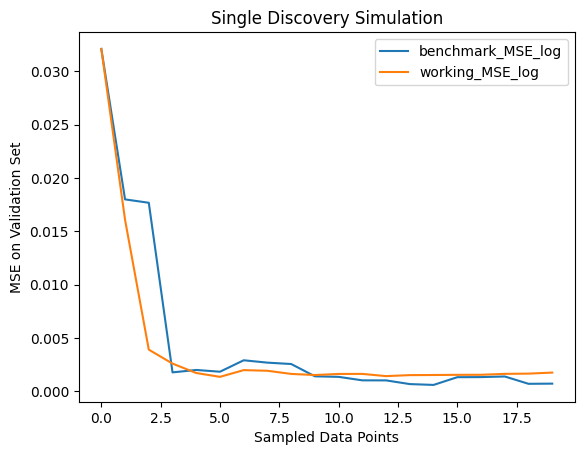

In [ ]:

# lets plot the benchmark_MSE_log and the workign_MSE_log
plt.plot(benchmark_MSE_log, label='benchmark_MSE_log')
plt.plot(working_MSE_log, label='working_MSE_log')
plt.xlabel('Sampled Data Points')
plt.ylabel('MSE on Validation Set')
plt.title('Single Discovery Simulation')
plt.legend()

# we can also investigate the final state more closely
# for example, these are all the experimental data collected
# under random sampling:
print(benchmark_state.experiment_data)
# and for your custom experimentalist
print(working_state.experiment_data)

### Visualize Prospect-Theory Results
Repeat the analysis with the prospect-theory ground truth to confirm the experimentalist's advantage on a second domain.

In [ ]:
# setting experiment runner and theorist
from autora.experiment_runner.synthetic.economics.prospect_theory import prospect_theory
experiment_runner = prospect_theory()


# run simulation
benchmark_MSE_log, working_MSE_log, benchmark_state, working_state = run_simulation(num_cycles, num_conditions_per_cycle, num_initial_conditions, bms_epochs, experiment_runner)

INFO:autora.theorist.bms.regressor:BMS fitting started


SIMULATION 0 / DISCOVERY CYCLE 0
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 61.02it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 68.06it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 1
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 62.76it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 59.83it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 2
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 55.78it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 60.34it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 3
Fitting models on benchmark state...


100%|██████████| 100/100 [00:02<00:00, 48.79it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 64.75it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 4
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 61.60it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 61.23it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 5
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 62.87it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 63.56it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 6
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 58.51it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 62.26it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 7
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 62.79it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 69.35it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 8
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 62.17it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 55.93it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 9
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 60.51it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 71.20it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 10
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 56.87it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 70.18it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 11
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 53.74it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 71.14it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 12
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 53.94it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 67.89it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 13
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 51.77it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 66.75it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 14
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 62.95it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:02<00:00, 47.34it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 15
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 62.27it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 69.54it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 16
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 58.50it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 74.40it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 17
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 59.72it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 68.06it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 18
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 57.30it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 63.28it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 19
Fitting models on benchmark state...


100%|██████████| 100/100 [00:01<00:00, 65.85it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...


100%|██████████| 100/100 [00:01<00:00, 60.94it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...


         V_A       P_A       V_B       P_B      choose_A
0   0.777778  0.666667  0.111111  0.222222  9.761819e-01
1   0.555556  0.555556 -0.333333  0.888889  9.998982e-01
2  -1.000000  0.666667  0.777778  0.555556  8.452803e-08
3   0.333333  0.555556 -1.000000  0.777778  9.999999e-01
4  -0.333333  0.222222  0.111111  0.555556  4.780458e-02
5  -0.777778  0.000000  0.555556  0.444444  8.790663e-02
6   0.111111  0.333333 -0.111111  0.111111  7.456815e-01
7   0.777778  0.777778  1.000000  0.000000  9.911984e-01
8  -0.333333  0.666667  1.000000  0.555556  8.965454e-05
9  -1.000000  0.777778  0.555556  1.000000  1.160580e-09
10 -0.777778  0.777778  0.333333  0.000000  8.182736e-06
11 -0.555556  0.777778  0.333333  0.888889  1.160780e-05
12 -0.555556  0.111111  0.777778  1.000000  2.903308e-05
13 -1.000000  0.444444  0.333333  0.222222  2.811201e-05
14  0.111111  0.333333  1.000000  0.333333  5.347289e-02
15  0.111111  0.444444  0.777778  1.000000  5.820712e-04
16  0.111111  0.111111 -1.00000

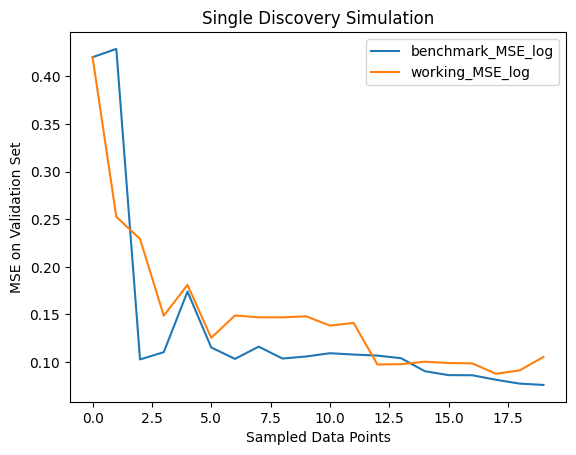

In [ ]:
# lets plot the benchmark_MSE_log and the workign_MSE_log
plt.plot(benchmark_MSE_log, label='benchmark_MSE_log')
plt.plot(working_MSE_log, label='working_MSE_log')
plt.xlabel('Sampled Data Points')
plt.ylabel('MSE on Validation Set')
plt.title('Single Discovery Simulation')
plt.legend()

# we can also investigate the final state more closely
# for example, these are all the experimental data collected
# under random sampling:
print(benchmark_state.experiment_data)
# and for your custom experimentalist
print(working_state.experiment_data)